# H1-B Visa Petitions

### Xun Zhou <br>  <br> 661966819 

## 1. Introductoion

The H1-B visa is an employment-based, non-immigrant visa category which allows foreigners to work legally in the United States at a company in a specialty occupation such as medicine, economics, computing, business and so on. It is usually applied for and held by international students with at least a bachelor's degree and work in a full time job.  

As an international student, I am interested in the H1-B petition process by nature. I would like to know what kind of job is more likely to be certified with H1b, which company is more willing to provide H1b sponsor, and in which states or cities were the foreigners able to find jobs?  

Moreover, this report is trying to identify the important factors that may affect the final status of H1-B Visa petitions, and predict the final status of the H1-B Visa petitions using various features. In this way, it provides a probability for both applicants and employers to predict the chances of being certified with H1-B visa and what aspects they should improve to increase their chances.  

This report will then be followed by four sections: Data Description; Analysis; Model Development and Application of model(s); Conclusions and Discussioning.

## 2. Data Description

This dataset comes from Kaggle. (https://www.kaggle.com/nsharan/h-1b-visa)

This dataset includes H-1B petitions data from 2011 to 2016 with 10 variables and about 3 million observations overall. Since this report is trying to predict whether the H1-B petition would be certified or not based on diverse features, the target variable would be the case status. And other 9 variables are listed as follow:

* Name of the employer: Name of employer sponsoring the H1-B visa.
* SOC Name：Occupational name along with the SOC code.
* Job title: Job title being requested. 
* Full time position: Where Y indicates a full time employment and N indicates a part time position.
* Prevailing wage: The annual prevailing wage for the requested occupation in USD amount.
* Year: Year when the H1-B visa petition was filed.
* Worksite: City and State information of this applicant's intended work region.
* Longitude: The longtitude of the corresponding worksite.
* Latitude: The latitude of the corresponding worksite.

Originally, the target variable - case status - has 7 levels as shown in plot 'THE DISTRIBUTION OF CASE STATUS'. But I will only consider the 'Certified' and 'Denied' ones.

In [1]:
import pandas as pd
import numpy as np
import difflib as dff
from sklearn import tree 
from sklearn import svm 
import sklearn.linear_model as linear_model 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, fbeta_score, recall_score, classification_report
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
h1b = pd.read_csv('../project/h1b_kaggle.csv')
h1b = h1b.loc[:, ~h1b.columns.str.contains('^Unnamed')]

In [3]:
h1b.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


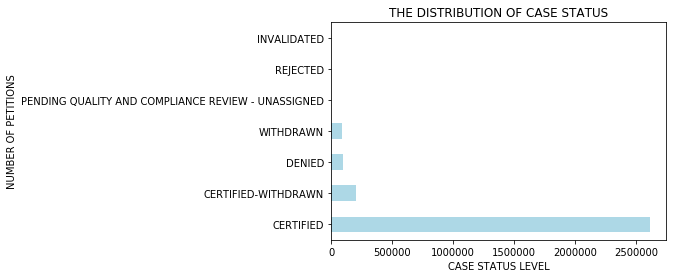

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64


In [4]:
plot_status_numberinit = h1b['CASE_STATUS'].value_counts().plot(title = 'THE DISTRIBUTION OF CASE STATUS', \
                                                                kind = 'barh', color = 'lightblue')
plot_status_numberinit.set_xlabel("CASE STATUS LEVEL")
plot_status_numberinit.set_ylabel("NUMBER OF PETITIONS")
plt.show()
print(h1b['CASE_STATUS'].value_counts())

## 3. Analysis

### 3.1 'Certified' and 'Denied'

Since this report only focused on the foreigners who were 'certified' or 'denied' with H1-B visa, the first thing I did was to remove 'rejected', 'invalid' and 'pending quality and compliance review - unassigned' ones in the dataset.

In [5]:
h1b_2 = h1b.loc[h1b['CASE_STATUS'].isin(["CERTIFIED", "DENIED"])]
print(h1b_2['CASE_STATUS'].value_counts())

# reset the index
h1b_2.reset_index(drop=True, inplace=True)
h1b_2.head()

CERTIFIED    2615623
DENIED         94346
Name: CASE_STATUS, dtype: int64


,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED,QUICKLOGIX LLC,CHIEF EXECUTIVES,CEO,Y,187200.0,2016.0,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108
1,CERTIFIED,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,"PRESIDENT, NORTHEAST REGION",Y,241842.0,2016.0,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835
2,CERTIFIED,"LOMICS, LLC",CHIEF EXECUTIVES,CEO,Y,99986.0,2016.0,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738
3,CERTIFIED,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,CHIEF EXECUTIVES,CHIEF FINANCIAL OFFICER,Y,99986.0,2016.0,"CHULA VISTA, CALIFORNIA",-117.084196,32.640054
4,CERTIFIED,"QUICKLOGIX, INC.",CHIEF EXECUTIVES,CEO,Y,187200.0,2016.0,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108


The value counts of case status shows that it is a highly imbalanced dataset. As you can see, the samples with certified status are far more than the ones with denied status.

So, data balancing becomes a very important step. Downsampling method may be used to resample the dataset in order to increase the model performance.


### 3.2 Dealing with Data Type

In [6]:
h1b_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709969 entries, 0 to 2709968
Data columns (total 10 columns):
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), object(6)
memory usage: 206.8+ MB


In [7]:
import warnings
warnings.filterwarnings("ignore")

h1b_2['EMPLOYER_NAME'] = h1b_2['EMPLOYER_NAME'].str.upper()
h1b_2['YEAR'] = h1b_2['YEAR'].astype(int)
h1b_2['SOC_NAME'] = h1b_2['SOC_NAME'].str.upper()
h1b_2['JOB_TITLE'] = h1b_2['JOB_TITLE'].str.upper()
h1b_2['FULL_TIME_POSITION'] = h1b_2['FULL_TIME_POSITION'].str.upper()
h1b_2['WORKSITE'] = h1b_2['WORKSITE'].str.upper()

In [8]:
h1b_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709969 entries, 0 to 2709968
Data columns (total 10 columns):
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  int64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 206.8+ MB


### 3.3 Missing Data

This dataset is not tidy and it includes missing values. I decided to first look into variables that contain missing valus.

In [9]:
h1b_2.isnull().sum()

CASE_STATUS               0
EMPLOYER_NAME            18
SOC_NAME              15893
JOB_TITLE                10
FULL_TIME_POSITION        1
PREVAILING_WAGE          53
YEAR                      0
WORKSITE                  0
lon                   97071
lat                   97071
dtype: int64

It can be found that there are few missing values in the most columns except for "lon" and "lat" columns. And even for this two columns, the percentage of missing data is only 3.3% of the entire dataset. So I decided to remove missing values in 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE', 'FULL_TIME_POSITION' and 'PREVAILING_WAGE'.

In [10]:
h1b_2=h1b_2.dropna(subset=['EMPLOYER_NAME', 'JOB_TITLE', 'SOC_NAME',\
                  'FULL_TIME_POSITION','PREVAILING_WAGE'])

Since the information that 'lon' and 'lat' convey can be covered by the the 'worksite' variables, I will drop this 2 variables.

In [11]:
h1b_2 = h1b_2.drop('lat', axis = 1)
h1b_2 = h1b_2.drop('lon', axis = 1)

In [12]:
h1b_2.isnull().sum()

CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
dtype: int64

### 3.4 Certified Rate Over Year 

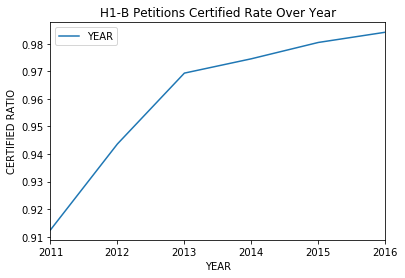

In [13]:
plot_certified_rate = pd.DataFrame(h1b_2[h1b_2['CASE_STATUS'] == 'CERTIFIED'].YEAR.value_counts() / h1b_2.YEAR.value_counts())
plot_certified_rate = plot_certified_rate.sort_values(['YEAR'])
plot_certified_rate = plot_certified_rate.plot(title = 'H1-B Petitions Certified Rate Over Year', kind = 'line')
plot_certified_rate.set_xlabel('YEAR')
plot_certified_rate.set_ylabel('CERTIFIED RATIO')
plt.show()

The plot 'H1-B Petitions Certified Rate Over Year' shows that the certified rate of H1-B petitions is increasing from 0.91 to 0.98 over years. Candidates are more likely to get certified than before.

### 3.5 Top 10 Employers Who Sponsor the H1-B 

INFOSYS LIMITED                      130241
TATA CONSULTANCY SERVICES LIMITED     64358
WIPRO LIMITED                         41719
DELOITTE CONSULTING LLP               36667
ACCENTURE LLP                         32983
IBM INDIA PRIVATE LIMITED             27875
MICROSOFT CORPORATION                 22373
HCL AMERICA, INC.                     22330
ERNST & YOUNG U.S. LLP                18217
CAPGEMINI AMERICA INC                 16032
Name: EMPLOYER_NAME, dtype: int64


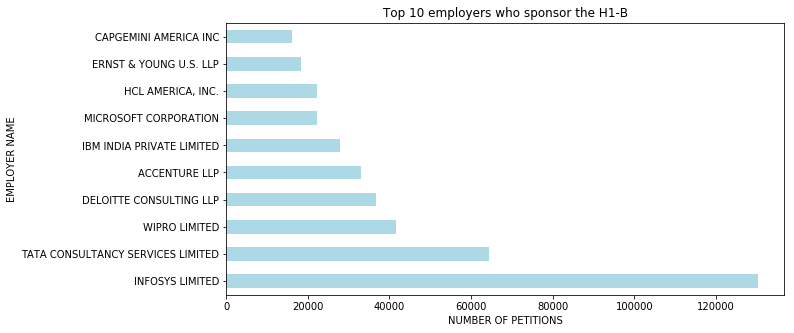

In [14]:
plot_top10emp= h1b_2['EMPLOYER_NAME'].value_counts().head(10).plot.barh(title = "Top 10 employers who sponsor the H1-B", \
                                                                 color = 'lightblue', figsize = (10, 5))
plot_top10emp.set_ylabel("EMPLOYER NAME")
plot_top10emp.set_xlabel("NUMBER OF PETITIONS")
plot_top10emp

print(h1b_2['EMPLOYER_NAME'].value_counts().head(10))

From the plot "Top 10 employers who sponsor the H1-B", it can be found that from 2011 to 2016, the INFOSYS LIMITED, TATA CONSULTANCY SERVICE, WIPRO LIMITED rank top 3 employer who sponsor the H1B and they are all Indian IT companies. International students who qualified should consider these companies first if they want to obtain H1-B.

### 3.6 Top 10 Job Title

PROGRAMMER ANALYST          225054
SOFTWARE ENGINEER           104672
COMPUTER PROGRAMMER          64860
SYSTEMS ANALYST              56521
SOFTWARE DEVELOPER           38650
BUSINESS ANALYST             35875
COMPUTER SYSTEMS ANALYST     32002
TECHNOLOGY LEAD - US         28312
TECHNOLOGY ANALYST - US      26013
SENIOR SOFTWARE ENGINEER     23863
Name: JOB_TITLE, dtype: int64


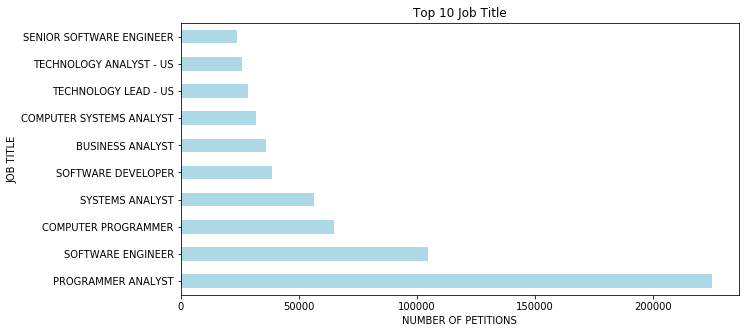

In [15]:
plot_top10soc= h1b_2['JOB_TITLE'].value_counts().head(10).plot.barh(title = "Top 10 Job Title", \
                                                                 color = 'lightblue', figsize = (10, 5))
plot_top10soc.set_ylabel("JOB TITLE")
plot_top10soc.set_xlabel("NUMBER OF PETITIONS")
plot_top10soc
print(h1b_2['JOB_TITLE'].value_counts().head(10))


The plot 'Top 10 Job Title' shows that from 2011 to 2016, 9 out of the 10 top job titles are all related to the computer science no wonder so many people want to study computer science.

### 3.7 Top 10 Worksites

NEW YORK, NEW YORK           170835
HOUSTON, TEXAS                73667
SAN FRANCISCO, CALIFORNIA     55816
ATLANTA, GEORGIA              47756
CHICAGO, ILLINOIS             46464
SAN JOSE, CALIFORNIA          44917
SUNNYVALE, CALIFORNIA         30653
DALLAS, TEXAS                 28556
CHARLOTTE, NORTH CAROLINA     28345
BOSTON, MASSACHUSETTS         27653
Name: WORKSITE, dtype: int64


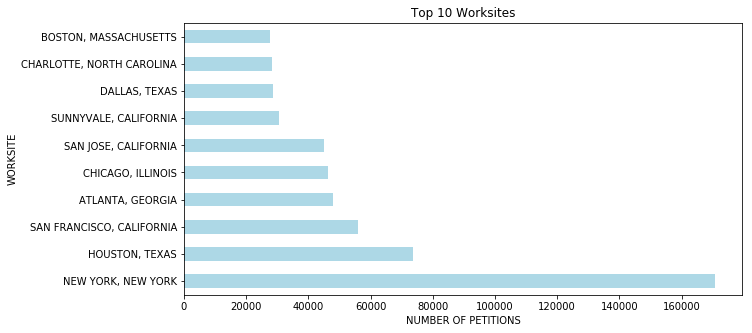

In [16]:
plot_top10region= h1b_2['WORKSITE'].value_counts().head(10).plot.barh(title = "Top 10 Worksites", \
                                                                 color = 'lightblue', figsize = (10, 5))
plot_top10region.set_ylabel("WORKSITE")
plot_top10region.set_xlabel("NUMBER OF PETITIONS")
plot_top10region
print(h1b_2['WORKSITE'].value_counts().head(10))

From the plot "Top 10 Worksites", it can be found that from 2011 to 2016, the NEW YORK, HOUSTON, SAN FRANCISCO, ATLANTA, CHICAGO are the most common cities where applicants work in.

### 3.8 Median Prevailing Wage Over Year

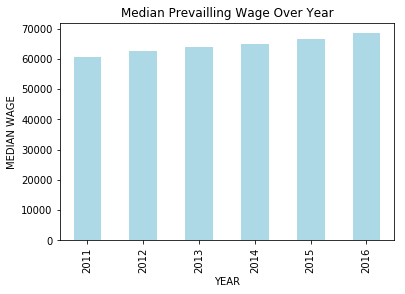

In [17]:
salary_over_year = h1b_2.loc[:,['PREVAILING_WAGE', 'YEAR']].groupby(['YEAR']).agg(['median'])

salary_over_year = salary_over_year.plot(kind = 'bar', color = 'lightblue', legend = None, title ='Median Prevailling Wage Over Year')
salary_over_year.set_xlabel('YEAR')
salary_over_year.set_ylabel('MEDIAN WAGE')
plt.show()
salary_over_year


In [18]:
# Show the calculated statistics
print("Minimum wage: ${:,.2f}".format(min(h1b_2['PREVAILING_WAGE'])))
print("Maximum wage: ${:,.2f}".format(max(h1b_2['PREVAILING_WAGE'])))
print("Mean wage: ${:,.2f}".format(np.mean(h1b_2['PREVAILING_WAGE'])))
print("Median wage ${:,.2f}".format(np.median(h1b_2['PREVAILING_WAGE'])))
print("Standard deviation of wage: ${:,.2f}".format(np.std(h1b_2['PREVAILING_WAGE'])))

Minimum wage: $0.00
Maximum wage: $6,997,606,720.00
Mean wage: $148,074.15
Median wage $65,027.50
Standard deviation of wage: $5,481,325.92


The plot 'Median Prevailing Wage Over Year' shows that the median prevailling wage is increasing from 2011 to 2016. Overall, the median prevailing wage is \$ 65,027.5 and the mean prevailing wage is $148,074.15. 

## 4. Model Development and Application of Models

### 4.1 Feature Engineering

First I checked the unique values for all variables before doing some further feature engineering. 

In [19]:
print("Unique Case Status ", h1b_2.CASE_STATUS.nunique())
print("Unique Employers ", h1b_2.EMPLOYER_NAME.nunique())
print("Prevailing Wages ", h1b_2.PREVAILING_WAGE.nunique())
print("Unique SOCs ", h1b_2.SOC_NAME.nunique())
print("Unique Job Titles ", h1b_2.JOB_TITLE.nunique())
print("Unique Year ", h1b_2.YEAR.nunique())
print("Unique Worksite State ", h1b_2.WORKSITE.nunique())
print("Unique Employment Type ", h1b_2.FULL_TIME_POSITION.nunique())

Unique Case Status  2
Unique Employers  231207
Prevailing Wages  54661
Unique SOCs  1515
Unique Job Titles  275785
Unique Year  6
Unique Worksite State  17785
Unique Employment Type  2


As we can see, there are too many unique values in EMPLOYER_NAME. It is impossible to use EMPLOYER_NAME directly in the model with so many unique values(levels). So I created a new variable name 'EMPLOYER_TYPE'. All the strings in EMPLOYER_NAME that contains 'UNIVERSITY' will have 'UNIVERSITY' as value in the 'EMPLOYER_TYPE' column. And the remaining ones will be filled with 'COMPANY'.

In [20]:
h1b_2['EMPLOYER_TYPE'] = np.nan
h1b_2.EMPLOYER_TYPE[h1b_2['EMPLOYER_NAME'].str.contains('UNIVERSITY')] = 'UNIVERSITY'
h1b_2['EMPLOYER_TYPE']= h1b_2.EMPLOYER_TYPE.replace(np.nan, 'COMPANY', regex=True)
h1b_2.EMPLOYER_TYPE.value_counts()

COMPANY       2579272
UNIVERSITY     114730
Name: EMPLOYER_TYPE, dtype: int64

I also dealt with the SOC_NAME. I created a new categorical variable 'OCCUPATION' to contain important information from 'SOC_NAME'. Specifically, since 'SOC_NAME' has provided enough information, I will not include 'JOB_TITLE' in the modeling.

In [21]:
warnings.filterwarnings("ignore")

h1b_2['OCCUPATION'] = np.nan
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('COMPUTER','PROGRAMMER')] = 'COMPUTER'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('SOFTWARE','DATABASE')] = 'COMPUTER'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('WEB DEVELOPER','INFORMATION')] = 'COMPUTER'

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('MATH','STATISTICS')] = 'MATH'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('MATHEMA','STATS')] = 'MATH'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('STATISTICIANS','PREDICTIVE MODEL')] = 'MATH'
                                                
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('TEACHER','LINGUIST')] = 'EDUCATION'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('PROFESSOR','TEACH')] = 'EDUCATION'        
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('SCHOOL PRINCIPAL')] = 'EDUCATION'   

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('PHYSICAL THERAPIST','SURGEON',)] = 'MEDICAL'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('MEDICAL','DOCTOR')] = 'MEDICAL'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('HEALTH')] = 'MEDICAL'                                          
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('NURSE','PSYCHIATR')] = 'MEDICAL'   
                                                
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('CHEMIST','BIOLOGY')] = 'ADVANCE SCIENCE'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('BIOLOGI','CLINICAL')] = 'ADVANCE SCIENCE'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('SCIENTIST','PHYSICITS')] = 'ADVANCE SCIENCE'

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('CHIEF','PLAN')] = 'MANAGEMENT'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('OPERATION','MANAGE')] = 'MANAGEMENT'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('EXECUTIVE','PUBLIC RELATION')] = 'MANAGEMENT'

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('ADVERTISE','ADVERTISING')] = 'MARKETING'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('MARKETING','PROMOTION')] = 'MARKETING'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('MARKET')] = 'MARKETING'

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('FINANCIAL','ACCOUNTANT')] = 'FINANCIAL & BUSINESS'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('FINANCE','BUSINESS')] = 'FINANCIAL & BUSINESS'

h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('ARCHITECT','SURVEYOR')] = 'ARCHITECTURE & ENGINEERING'
h1b_2.OCCUPATION[h1b_2['SOC_NAME'].str.contains('CARTO','DRAFTER')] = 'ARCHITECTURE & ENGINEERING'
h1b_2['OCCUPATION']= h1b_2.OCCUPATION.replace(np.nan, 'OTHER', regex=True)

In [22]:
h1b_2.OCCUPATION.value_counts()

COMPUTER                      1676226
OTHER                          576653
ADVANCE SCIENCE                101617
EDUCATION                       65926
FINANCIAL & BUSINESS            65425
MEDICAL                         58242
MARKETING                       54319
MANAGEMENT                      53763
ARCHITECTURE & ENGINEERING      24961
MATH                            16870
Name: OCCUPATION, dtype: int64

For the 'WORKSITE' variable， I extracted state information from it and created a new variable 'STATE'.

In [23]:
def State(WORK_SITE):
    return WORK_SITE.split(', ')[1]

h1b_2['STATE'] = h1b_2['WORKSITE'].apply(State)


In [24]:
h1b_2['STATE'].value_counts()

CALIFORNIA              497077
TEXAS                   262450
NEW YORK                261280
NEW JERSEY              194532
ILLINOIS                145385
MASSACHUSETTS           103288
PENNSYLVANIA            100382
FLORIDA                  96796
GEORGIA                  94016
WASHINGTON               91744
VIRGINIA                 80834
MICHIGAN                 74169
NORTH CAROLINA           72046
OHIO                     69730
MARYLAND                 49680
CONNECTICUT              45642
MINNESOTA                44648
ARIZONA                  37908
MISSOURI                 30901
WISCONSIN                29784
COLORADO                 27990
INDIANA                  26510
TENNESSEE                24574
OREGON                   21361
DISTRICT OF COLUMBIA     20347
DELAWARE                 16177
IOWA                     14773
ARKANSAS                 13579
KANSAS                   12349
UTAH                     11857
SOUTH CAROLINA           11620
KENTUCKY                 11608
RHODE IS

Then I dealt with the target variable 'CASE_STATUS' by classifing 'CERTIFIED' into 1, and 'DENIED' into 0.

In [25]:
class_mapping = {'CERTIFIED':1, 'DENIED':0}
h1b_2['CASE_STATUS'] = h1b_2['CASE_STATUS'].map(class_mapping)

The next thing is to drop features I don't need.

In [26]:
h1b_2 = h1b_2.drop('EMPLOYER_NAME', axis = 1)
h1b_2 = h1b_2.drop('SOC_NAME', axis = 1)
h1b_2 = h1b_2.drop('JOB_TITLE', axis = 1)
h1b_2 = h1b_2.drop('WORKSITE', axis = 1)

In [27]:
h1b_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694002 entries, 0 to 2709968
Data columns (total 7 columns):
CASE_STATUS           int64
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  int64
EMPLOYER_TYPE         object
OCCUPATION            object
STATE                 object
dtypes: float64(1), int64(2), object(4)
memory usage: 244.4+ MB


In [28]:
h1b_2[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','EMPLOYER_TYPE','OCCUPATION','STATE']] = h1b_2[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','EMPLOYER_TYPE','OCCUPATION','STATE']].apply(lambda x: x.astype('category'))

In [29]:
h1b_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694002 entries, 0 to 2709968
Data columns (total 7 columns):
CASE_STATUS           category
FULL_TIME_POSITION    category
PREVAILING_WAGE       float64
YEAR                  category
EMPLOYER_TYPE         category
OCCUPATION            category
STATE                 category
dtypes: category(6), float64(1)
memory usage: 136.5 MB


### 4.2 Resampling

As I mentioned before, it is a imbalanced dataset and may need casuse bad model performace. In order to deal with it, I would randomly downsampling the dataset. After downsampling, the datasize will be 187522 with balanced CASE_STATUS.

In [30]:
h1b_2.CASE_STATUS.value_counts()

1    2600241
0      93761
Name: CASE_STATUS, dtype: int64

In [31]:
from sklearn.utils import resample
h1b_2_majority = h1b_2[h1b_2.CASE_STATUS==1]
h1b_2_minority = h1b_2[h1b_2.CASE_STATUS==0]
 
# Downsample majority class
h1b_2_majority_downsampled = resample(h1b_2_majority, 
                                      replace=False,       # sample without replacement
                                      n_samples=93761,     # to match minority class
                                      random_state=123)    # reproducible results
 
# Combine minority class with downsampled majority class
h1b_2_downsampled = pd.concat([h1b_2_majority_downsampled, h1b_2_minority])

In [32]:
h1b_2_downsampled.CASE_STATUS.value_counts()

1    93761
0    93761
Name: CASE_STATUS, dtype: int64

In [33]:
h1b_2_downsampled.head()

,CASE_STATUS,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,EMPLOYER_TYPE,OCCUPATION,STATE
667607,1,Y,63506.0,2015,UNIVERSITY,MEDICAL,PENNSYLVANIA
2245746,1,Y,99653.0,2012,COMPANY,COMPUTER,CALIFORNIA
71246,1,Y,93059.2,2016,COMPANY,ADVANCE SCIENCE,TENNESSEE
1688566,1,Y,62275.0,2013,COMPANY,COMPUTER,ARIZONA
1777733,1,Y,100984.0,2013,COMPANY,COMPUTER,CALIFORNIA


In [34]:
h1b_2_downsampled.isnull().sum()

CASE_STATUS           0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
EMPLOYER_TYPE         0
OCCUPATION            0
STATE                 0
dtype: int64

### 4.3 Cross Validation

In order to evaluate model performance in a more accurate way, I created cross validation by seperating the downsampling dataset into train(70%） & test（30%） dataset. 

In [35]:
X = h1b_2_downsampled.drop('CASE_STATUS', axis=1)
y = h1b_2_downsampled.CASE_STATUS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape

(131265, 6)

In [36]:
X_train.isnull().sum()

FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
EMPLOYER_TYPE         0
OCCUPATION            0
STATE                 0
dtype: int64

In [37]:
X_train.dtypes

FULL_TIME_POSITION    category
PREVAILING_WAGE        float64
YEAR                  category
EMPLOYER_TYPE         category
OCCUPATION            category
STATE                 category
dtype: object

In [38]:
y_train.isnull().sum()

0

In [39]:
X_test.isnull().sum()

FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
EMPLOYER_TYPE         0
OCCUPATION            0
STATE                 0
dtype: int64

In [40]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [41]:
X_train.head()

,PREVAILING_WAGE,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y,YEAR_2011,YEAR_2012,YEAR_2013,YEAR_2014,YEAR_2015,YEAR_2016,EMPLOYER_TYPE_COMPANY,...,STATE_SOUTH DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WASHINGTON,STATE_WEST VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
27489,134888.0,0,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2678047,58531.0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1746846,37336.0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2120573,80960.0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1954128,50950.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.4 Naive Bayes Classifier

The first model I chose is Naive Bayes Model. It is used to estimate the probability of the target variable 'CASE_STATUS' given features I selected. To evaluate the performance of this model, I construted the confusion matrix and reported the precision, recall, F1-score. It can be found that the precision for this model is 0.75 on average. The recall is only 0.51 and the F1-score is barely 0.36. And in order to better judge its performance, I also created ROC plot and calculated the AUC. The auc of this model is only 0.51, so the performance of this model is not very well.

In [42]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred_NB = NB.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_NB))
print(metrics.classification_report(y_test, y_pred_NB))


[[  566 27426]
 [    1 28264]]
             precision    recall  f1-score   support

          0       1.00      0.02      0.04     27992
          1       0.51      1.00      0.67     28265

avg / total       0.75      0.51      0.36     56257



AUC: 0.5100923417152822


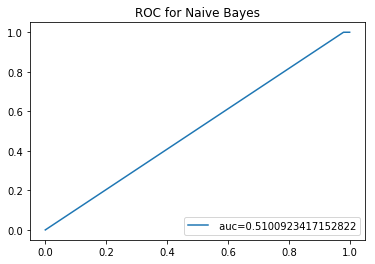

In [43]:
fpr_NB, tpr_NB, thresholds = metrics.roc_curve(y_test, y_pred_NB)
print('AUC:',metrics.auc(fpr_NB, tpr_NB))
auc_NB = np.trapz(tpr_NB,fpr_NB)
plt.plot(fpr_NB,tpr_NB,label=" auc="+str(auc_NB))
plt.legend(loc=4)
plt.title('ROC for Naive Bayes')
plt.show()

### 4.5 Decision Trees Model

Decision Trees is the second model I applied to predict the outcome of 'CASE_STATUS'. According to the confusion matrix and classification report, the precision, recall, and F1-score for this model are all 0.67 on average. Meantime, the ROC curve below shows that the AUC is 0.67. Compared with the first model, it performs much better. 

And I also showed tha feature importance. It can be found that PREVAILING_WAGE, OCCUPATION_COMPUTER, YEAR_2011, YEAR_2012, STATE_CALIFORNIA are the top 5 important features.

In [44]:
Dtree = tree.DecisionTreeClassifier(random_state = 123)
Dtree = Dtree.fit(X_train, y_train) 

In [45]:
y_pred_D = Dtree.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred_D))
print(metrics.classification_report(y_test, y_pred_D))

[[18505  9487]
 [ 9150 19115]]
             precision    recall  f1-score   support

          0       0.67      0.66      0.67     27992
          1       0.67      0.68      0.67     28265

avg / total       0.67      0.67      0.67     56257



AUC: 0.6686799100367156


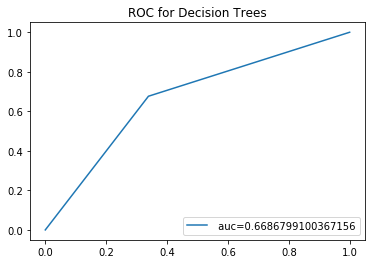

In [46]:
fpr_D, tpr_D, thresholds = metrics.roc_curve(y_test, y_pred_D)
print('AUC:',metrics.auc(fpr_D, tpr_D))
auc_D = np.trapz(tpr_D,fpr_D)
plt.plot(fpr_D,tpr_D,label=" auc="+str(auc_D))
plt.legend(loc=4)
plt.title('ROC for Decision Trees')
plt.show()

In [47]:
feature_importances_Dtree = pd.DataFrame(Dtree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_Dtree.head(10)

,importance
PREVAILING_WAGE,0.486097
OCCUPATION_COMPUTER,0.130576
YEAR_2011,0.053344
YEAR_2012,0.028598
STATE_CALIFORNIA,0.013797
STATE_TEXAS,0.013451
STATE_NEW YORK,0.012854
OCCUPATION_OTHER,0.010493
STATE_NEW JERSEY,0.009555
STATE_MASSACHUSETTS,0.009393


### 4.6 Random Forest

From experience, random forest based on many decision trees and each of these decision tree takes a subset of independent variables randomly. In this way, the diversity increases and a more robust prediction result can be achieved. 

However, the precision, recall, F1-score both stay the same with Decision Trees model. And the AUC is 0.673, a little higher than Decision Trees model. 

Different from the decision trees, PREVAILING_WAGE, OCCUPATION_COMPUTER, YEAR_2011, OCCUPATION_OTHER, YEAR_2016 are the top 5 important features.

In [48]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 123)
rf.fit(X_train, y_train)

y_pred_rf =  rf.predict(X_test)

print(metrics.confusion_matrix(y_test,y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))

[[18018  9974]
 [ 8411 19854]]
             precision    recall  f1-score   support

          0       0.68      0.64      0.66     27992
          1       0.67      0.70      0.68     28265

avg / total       0.67      0.67      0.67     56257



In [49]:
import pandas as pd
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_rf.head(10)

,importance
PREVAILING_WAGE,0.650170
OCCUPATION_COMPUTER,0.064475
YEAR_2011,0.047463
OCCUPATION_OTHER,0.025399
YEAR_2016,0.019620
YEAR_2012,0.013694
YEAR_2015,0.012275
YEAR_2014,0.006173
FULL_TIME_POSITION_Y,0.005654
FULL_TIME_POSITION_N,0.005552


AUC: 0.6730537008198294


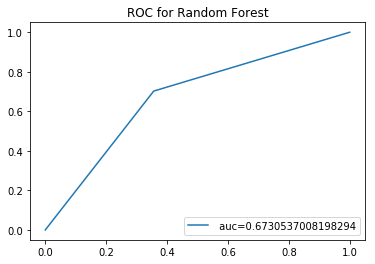

In [50]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_pred_rf)
print('AUC:',metrics.auc(fpr_rf, tpr_rf))
auc_rf = np.trapz(tpr_rf,fpr_rf)
plt.plot(fpr_rf,tpr_rf,label=" auc="+str(auc_rf))
plt.legend(loc=4)
plt.title('ROC for Random Forest')
plt.show()

### 4.6 Model Tuning

For decision trees, I tried to tune it by changing the max_depth and min_sample_leaf. When I changed max_depth and min_sample_leaf to 13, the precision, recall, F1-score both increased to 0.687. And the AUC also increased to 0.687. 

The feature importance changed. OCCUPATION_COMPUTER, PREVAILING_WAGE, YEAR_2011, YEAR_2012,OCCUPATION_OTHER, YEAR_2016 are the top 5 important features.

In [51]:
Dtree = tree.DecisionTreeClassifier(random_state = 123, max_depth = 13, min_samples_leaf = 13)
Dtree = Dtree.fit(X_train, y_train) 
y_pred_D = Dtree.predict(X_test)


print(metrics.confusion_matrix(y_test,y_pred_D))
print(metrics.classification_report(y_test, y_pred_D))


[[19139  8853]
 [ 8771 19494]]
             precision    recall  f1-score   support

          0       0.69      0.68      0.68     27992
          1       0.69      0.69      0.69     28265

avg / total       0.69      0.69      0.69     56257



AUC: 0.6867089789673296


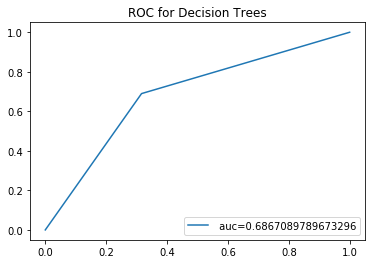

In [52]:
fpr_D, tpr_D, thresholds = metrics.roc_curve(y_test, y_pred_D)
print('AUC:',metrics.auc(fpr_D, tpr_D))
auc_D = np.trapz(tpr_D,fpr_D)
plt.plot(fpr_D,tpr_D,label=" auc="+str(auc_D))
plt.legend(loc=4)
plt.title('ROC for Decision Trees')
plt.show()

In [53]:
feature_importances_Dtree = pd.DataFrame(Dtree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_Dtree.head(10)

,importance
OCCUPATION_COMPUTER,0.417646
PREVAILING_WAGE,0.202524
YEAR_2011,0.170619
YEAR_2012,0.091470
EMPLOYER_TYPE_UNIVERSITY,0.015278
OCCUPATION_ADVANCE SCIENCE,0.012279
YEAR_2013,0.009344
FULL_TIME_POSITION_N,0.008151
YEAR_2016,0.007508
FULL_TIME_POSITION_Y,0.006830


For Random Tree, I increased the n_estimators to 100, and changed the max_depth to 14. The precision, recall, F1-score both increased to 0.69. And the AUC also increased to 0.692. 

The top 5 important features didn't change.

In [54]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 14, random_state = 123)
rf.fit(X_train, y_train)

y_pred_rf =  rf.predict(X_test)

print(metrics.confusion_matrix(y_test,y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))

[[19376  8616]
 [ 8700 19565]]
             precision    recall  f1-score   support

          0       0.69      0.69      0.69     27992
          1       0.69      0.69      0.69     28265

avg / total       0.69      0.69      0.69     56257



AUC: 0.6921983016349924


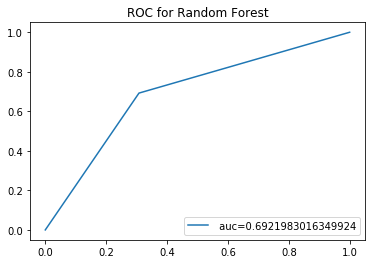

In [55]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_pred_rf)
print('AUC:',metrics.auc(fpr_rf, tpr_rf))
auc_rf = np.trapz(tpr_rf,fpr_rf)
plt.plot(fpr_rf,tpr_rf,label=" auc="+str(auc_rf))
plt.legend(loc=4)
plt.title('ROC for Random Forest')
plt.show()

In [56]:
import pandas as pd
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_rf.head(10)

,importance
OCCUPATION_COMPUTER,0.229829
PREVAILING_WAGE,0.208385
YEAR_2011,0.156846
OCCUPATION_OTHER,0.083195
YEAR_2016,0.070531
YEAR_2015,0.041978
YEAR_2012,0.036135
YEAR_2014,0.016300
FULL_TIME_POSITION_N,0.016118
FULL_TIME_POSITION_Y,0.013579


## 5. Conclusions and Discussion

This report applied three models to identify the important factors that influence the final status of H1-B visa petitions and also tried to predict the final outcome of H1-B visa petitions.

The most important part in this report is selecting independent variables and feature engineering. The target variable is the 'CASE_STATUS' where Certified = 1 and Denied = 0. The independent variables includes 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'EMPLOYER_TYPE', 'OCCUPATION', 'STATE'. Among these variables, 'EMPLOYER_TYPE' was created from 'EMPLOYER_NAME'. All the strings in 'EMPLOYER_NAME' that contains 'UNIVERSITY' had 'UNIVERSITY' as value in the 'EMPLOYER_TYPE' column. And the remaining ones were filled with 'COMPANY'. 'OCCUPATION' is a categorical variable which contains important information from 'SOC_NAME'. 'STATE' was extracted from the 'WORKSITE' variable.

To deal with the imbalanced problem, I utilized downsampling method to randomly resample without replacement from the 'Certified' class to create a new subset of observation equal in size to the 'Denied' class. Then I split it into training and test set.

In the modeling part, since it is a supervised binary classification problem, the first model I chose is Naive Bayes Model. It can be found that the precision for this model is 0.75 on average. The recall is only 0.51 and the F1-score is barely 0.36. More importantly, the AUC for this model is only 0.51.

Decision Trees is the second model. Initially, the precision, recall, and F1-score for this model are all 0.67 on average. Meantime, the ROC curve below shows that the AUC is 0.67. Compared with the first model, it performs much better. I also showed tha feature importance. It can be found that 'PREVAILING_WAGE', 'OCCUPATION_COMPUTER', 'YEAR_2011', 'YEAR_2012', 'STATE_CALIFORNIA' are the top 5 important features. I tried to tune it by changing the max_depth and min_sample_leaf to 13, After tuning, according to the confusion matrix and classification report, the precision, recall, and F1-score for this model are 0.687 . The AUC increased to 0.686. 'OCCUPATION_COMPUTER', 'PREVAILING_WAGE', 'YEAR_2011', 'YEAR_2012', 'OCCUPATION_OTHER', 'YEAR_2016' are the top 5 important features. Compared with the first model, it performs much better. 

From experience, random forest based on many decision trees and each of these decision tree takes a subset of independent variables randomly. In this way, the diversity increases and a more robust prediction result can be achieved. However, the precision, recall, F1-score and the AUC didn't improve much. I tried to tune it by increasing the n_estimators to 100, and changing the max_depth to 14. The precision, recall, F1-score both increased to 0.69. And the AUC also increased to 0.692. Different from the decision trees, 'PREVAILING_WAGE', 'OCCUPATION_COMPUTER', 'YEAR_2011', 'OCCUPATION_OTHER', 'YEAR_2016' are the top 5 important features. Random forest has the best performance.

In future, I will try to modify the feature engineering by extracting as much information as I can from the features to make the model more accurate and robust. I will also try to use oversampling method to incrase the sample size. Last but not least, I will try other classification methods such as Extreme Gradient Boosting to increase the predicting power. 


AUC: 0.5100923417152822


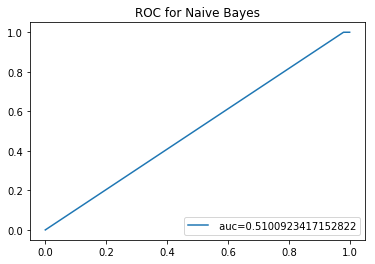

In [57]:
fpr_NB, tpr_NB, thresholds = metrics.roc_curve(y_test, y_pred_NB)
print('AUC:',metrics.auc(fpr_NB, tpr_NB))
auc_NB = np.trapz(tpr_NB,fpr_NB)
plt.plot(fpr_NB,tpr_NB,label=" auc="+str(auc_NB))
plt.legend(loc=4)
plt.title('ROC for Naive Bayes')
plt.show()

AUC: 0.6867089789673296


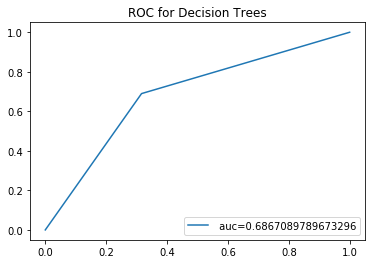

In [58]:
fpr_D, tpr_D, thresholds = metrics.roc_curve(y_test, y_pred_D)
print('AUC:',metrics.auc(fpr_D, tpr_D))
auc_D = np.trapz(tpr_D,fpr_D)
plt.plot(fpr_D,tpr_D,label=" auc="+str(auc_D))
plt.legend(loc=4)
plt.title('ROC for Decision Trees')
plt.show()

AUC: 0.6921983016349924


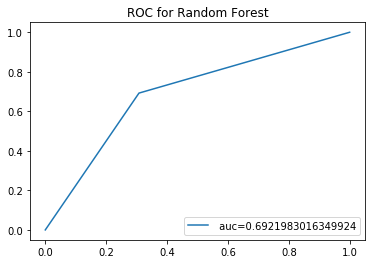

In [59]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_pred_rf)
print('AUC:',metrics.auc(fpr_rf, tpr_rf))
auc_rf = np.trapz(tpr_rf,fpr_rf)
plt.plot(fpr_rf,tpr_rf,label=" auc="+str(auc_rf))
plt.legend(loc=4)
plt.title('ROC for Random Forest')
plt.show()

## Reference

https://www.kaggle.com/nsharan/h-1b-visa

https://elitedatascience.com/imbalanced-classes

https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://www.kaggle.com/nmcuong81/h1-b-analysis-and-predictions
